# Fútbol y Apuestas

> Análisis de las **apuestas de fútbol** desde la temporada 2004/2005, con el fin de analizar el **índice de acierto por año**.

> Análisis de las **victorias de equipos** de fútbol desde 2004/2005, con el fin de analizar el **índice de victorias al jugar como local o como invitado**.

> Análisis de la **evolución goleadora** desde la temporada 2004/2005, con el fin de determinar la **tendencia hacia un estilo de juego más ofensivo o defensivo** a lo largo de los años.

> Creación de una **clasificación histórica acumulada (Supertabla)**, con el fin de identificar a los **equipos más regulares y con mejor rendimiento global** desde 2002.

> Análisis de los **umbrales de puntuación para el descenso y competiciones europeas**, con el fin de medir la **competitividad de la liga** y la brecha de puntos entre la élite y el resto de equipos.

## Carga y Limpieza de Datos

In [20]:
# Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Definir la ruta local a la carpeta "datos"
# Asegúrate de que esta carpeta esté en el mismo directorio que tu script
carpeta = "datos"

# Verificar si la carpeta existe para evitar errores
if not os.path.exists(carpeta):
    print(f"Error: La carpeta '{carpeta}' no existe en el directorio actual.")
    todos_archivos = []
else:
    todos_archivos = [f for f in os.listdir(carpeta) if f.endswith(".csv")]

df_list = []
for archivo in todos_archivos:
    try:
        # Cargar archivo desde la carpeta local
        temp = pd.read_csv(os.path.join(carpeta, archivo), on_bad_lines='skip', engine='python')
        df_list.append(temp)
    except Exception as e:
        print(f"Error al leer {archivo}: {e}")
        continue

# Solo concatenar si se encontraron archivos válidos
if df_list:
    df = pd.concat(df_list, ignore_index=True)

    # --- Diagnóstico de fechas ---
    print(f"Filas iniciales antes de limpiar fechas: {df.shape[0]}")
    
    # Arreglar las fechas
    # Intentar con el primer formato (DD/MM/YY)
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y', errors='coerce')

    # Identificar filas que aún son NaT y probar con el segundo formato (DD/MM/YYYY)
    mask_nat_1 = df['Date'].isna()
    df.loc[mask_nat_1, 'Date'] = pd.to_datetime(df.loc[mask_nat_1, 'Date'], format='%d/%m/%Y', errors='coerce')

    # Identificar filas que aún son NaT y probar con el tercer formato (YYYY-MM-DD)
    mask_nat_2 = df['Date'].isna()
    df.loc[mask_nat_2, 'Date'] = pd.to_datetime(df.loc[mask_nat_2, 'Date'], format='%Y-%m-%d', errors='coerce')

    # Eliminar filas donde la fecha sigue siendo inválida (NaT)
    df = df.dropna(subset=['Date'])

    print(f"Filas después de limpiar fechas: {df.shape[0]}")
    print(f"Mínima fecha después de limpiar: {df['Date'].min()}")
    # ------------------------------

    year = df['Date'].dt.year
    month = df['Date'].dt.month

    # Lógica de temporadas
    df['Temporada'] = np.where(month > 7,
                               year.astype(str).str[2:] + '/' + (year + 1).astype(str).str[2:],
                               (year - 1).astype(str).str[2:] + '/' + year.astype(str).str[2:])

    # Comprobación
    print("Primeras 5 filas del DataFrame con la nueva columna 'Temporada':")
    print(df[['Date', 'Temporada', 'HomeTeam', 'AwayTeam']].head())
else:
    print("No se cargaron datos. Revisa que haya archivos .csv en la carpeta 'datos'.")

Filas iniciales antes de limpiar fechas: 8628
Filas después de limpiar fechas: 5968
Mínima fecha después de limpiar: 2002-08-31 00:00:00
Primeras 5 filas del DataFrame con la nueva columna 'Temporada':
        Date Temporada    HomeTeam    AwayTeam
0 2002-08-31     02/03   Santander  Valladolid
1 2002-09-01     02/03   Barcelona  Ath Madrid
2 2002-09-01     02/03   La Coruna       Betis
3 2002-09-01     02/03    Mallorca    Valencia
4 2002-09-01     02/03  Recreativo      Malaga


C:\Users\daw\AppData\Local\Temp\ipykernel_12280\712557607.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Temporada'] = np.where(month > 7,


## 1. Total de Partidos Jugados por Año

           Partidos
Temporada          
02/03           380
03/04           380
04/05           268
05/06           380
06/07           380


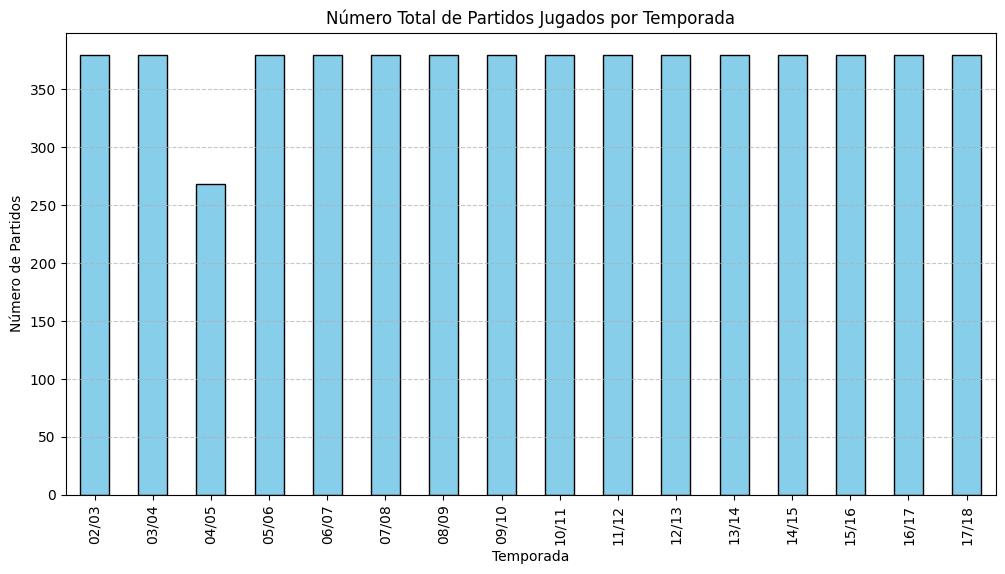

In [21]:
# TABLA DE PARTIDOS
partidos_por_temporada = df.groupby('Temporada').agg(
    Partidos=('Temporada', 'count')
)

print(partidos_por_temporada.head())

# GRÁFICO DE BARRAS
plt.figure(figsize=(12, 6))
partidos_por_temporada['Partidos'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Número Total de Partidos Jugados por Temporada')
plt.ylabel('Número de Partidos')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 2. Goles por Partido por Temporada

Promedio de goles por partido por temporada (primeras 5 filas):
           TotalGoles  Partidos  Goles_Por_Partido
Temporada                                         
02/03            1016       380           2.673684
03/04            1015       380           2.671053
04/05             693       268           2.585821
05/06             936       380           2.463158
06/07             942       380           2.478947


C:\Users\daw\AppData\Local\Temp\ipykernel_12280\4055992220.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['TotalGoles'] = df['FTHG'] + df['FTAG']


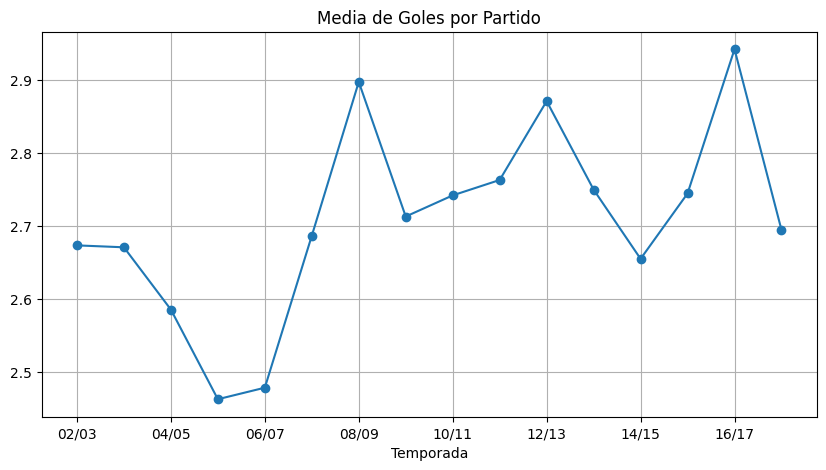

In [22]:
df['TotalGoles'] = df['FTHG'] + df['FTAG']

# Tabla
goles_por_temporada = df.groupby('Temporada').agg(
    TotalGoles=('TotalGoles', 'sum'),
    Partidos=('Temporada', 'count')
)
goles_por_temporada['Goles_Por_Partido'] = goles_por_temporada['TotalGoles'] / goles_por_temporada['Partidos']

print("Promedio de goles por partido por temporada (primeras 5 filas):")
print(goles_por_temporada.head())

# Gráfico de líneas como en tu notebook
goles_por_temporada['Goles_Por_Partido'].plot(kind='line', marker='o', figsize=(10,5), title='Media de Goles por Partido')
plt.grid(True)
plt.show()

## 3. Distribución Porcentual de Resultados de Partidos

C:\Users\daw\AppData\Local\Temp\ipykernel_12280\916372501.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Locales vs Visitante'] = df['FTR'].map({'H': 'Local', 'A': 'Visitante', 'D': 'Empate'})


Recuento de resultados:
Locales vs Visitante
Local        2846
Visitante    1681
Empate       1441
Name: count, dtype: int64


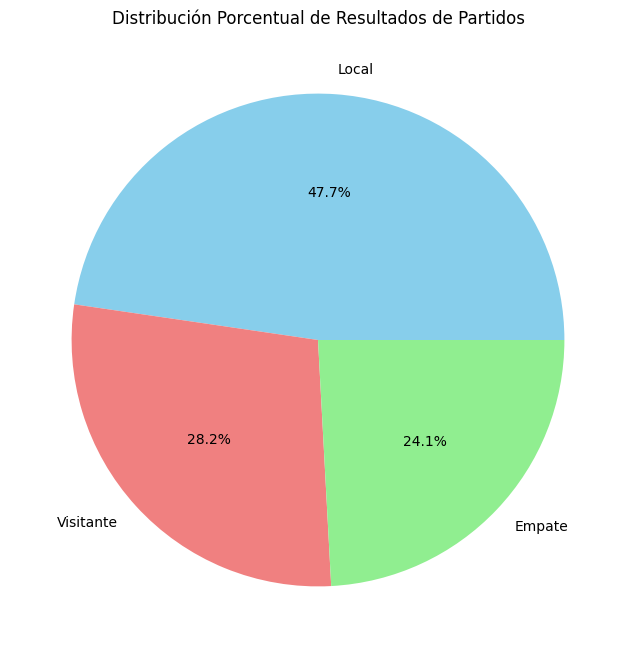

In [23]:
# Traducimos los valores para que el reporte sea en español
df['Locales vs Visitante'] = df['FTR'].map({'H': 'Local', 'A': 'Visitante', 'D': 'Empate'})

# Tabla
print("Recuento de resultados:")
indice_victorias = df['Locales vs Visitante'].value_counts()
print(indice_victorias)

# Gráfico
porcentaje_resultados = df['Locales vs Visitante'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 8))
porcentaje_resultados.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen'])

plt.title('Distribución Porcentual de Resultados de Partidos')
plt.ylabel('')
plt.show()

## 4. Análisis de Rendimiento por Equipo (Efectividad y Puntos)

In [ ]:
# Calcular métricas de rendimiento por equipo (Home + Away)
home_stats = df.groupby('HomeTeam').agg({
    'FTR': lambda x: (x == 'H').sum(),
    'Date': 'count'
}).rename(columns={'FTR': 'Wins_H', 'Date': 'Played_H'})

away_stats = df.groupby('AwayTeam').agg({
    'FTR': lambda x: (x == 'A').sum(),
    'Date': 'count'
}).rename(columns={'FTR': 'Wins_A', 'Date': 'Played_A'})

rendimiento = home_stats.join(away_stats, how='outer').fillna(0)
rendimiento['Total_Played'] = rendimiento['Played_H'] + rendimiento['Played_A']
rendimiento['Total_Wins'] = rendimiento['Wins_H'] + rendimiento['Wins_A']
rendimiento['Efectividad'] = (rendimiento['Total_Wins'] / rendimiento['Total_Played']) * 100

# Visualizar equipos con más de 50 partidos jugados
top_rendimiento = rendimiento[rendimiento['Total_Played'] >= 50].sort_values('Efectividad', ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_rendimiento['Efectividad'].plot(kind='bar', color='green', alpha=0.6)
plt.title('Top 10 Equipos por Efectividad Histórica (Tasa de Victoria)')
plt.ylabel('Efectividad (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

## 5. Distribución Porcentual de Resultados por Temporada

In [ ]:
# Traducimos los valores
df['Locales vs Visitante'] = df['FTR'].map({'H': 'Local', 'A': 'Visitante', 'D': 'Empate'})

# Obtenemos las temporadas únicas y las ordenamos
temporadas = sorted(df['Temporada'].unique())
n_temporadas = len(temporadas)

# Calculamos cuántas filas y columnas necesitamos para los subplots
n_cols = 3  # 3 gráficos por fila
n_rows = (n_temporadas + n_cols - 1) // n_cols

# Creamos la figura con subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
axes = axes.flatten()  # Aplanamos para facilitar la iteración

# Creamos un gráfico de pie para cada temporada
for i, temporada in enumerate(temporadas):
    df_temp = df[df['Temporada'] == temporada]
    porcentaje_resultados = df_temp['Locales vs Visitante'].value_counts(normalize=True) * 100

    axes[i].pie(porcentaje_resultados, labels=porcentaje_resultados.index,
                autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen'],
                startangle=90)
    axes[i].set_title(f'Temporada {temporada}', fontsize=12, fontweight='bold')

# Ocultamos los ejes sobrantes si hay
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Distribución Porcentual de Resultados por Temporada',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Tabla resumen por temporada
print("\nRecuento de resultados por temporada:")
tabla_temporadas = pd.crosstab(df['Temporada'], df['Locales vs Visitante'])
print(tabla_temporadas)

print("\nPorcentaje de resultados por temporada:")
porcentaje_tabla = pd.crosstab(df['Temporada'], df['Locales vs Visitante'], normalize='index') * 100
print(porcentaje_tabla.round(2))

## 6. Top 10 equipos con más puntos

Top 10 Equipos en la Supertabla Histórica:
             Puntos_Totales
HomeTeam                   
Barcelona              1343
Real Madrid            1326
Ath Madrid             1029
Valencia                986
Sevilla                 963
Villarreal              877
Ath Bilbao              819
Espanol                 735
La Coruna               655
Sociedad                648


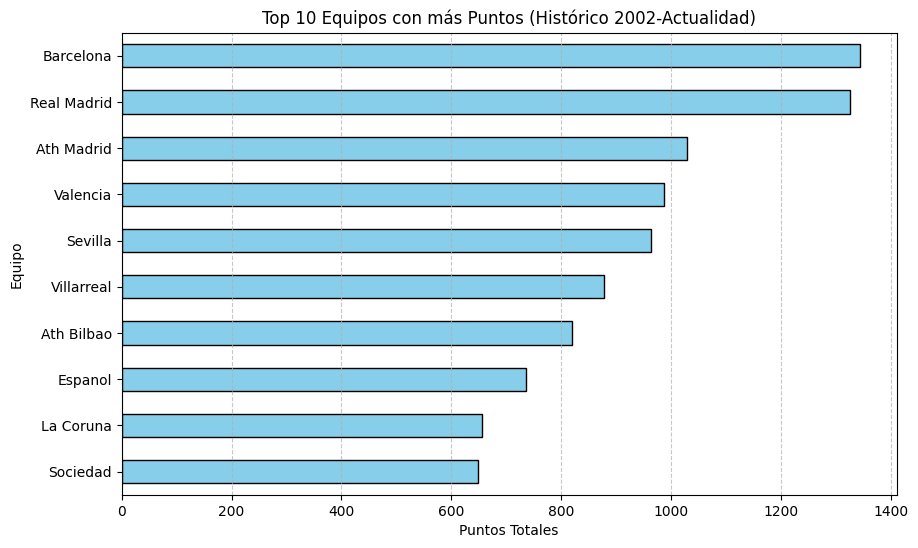

In [24]:
# Clasificación acumulada de todos los tiempos
puntos_L = df[df['FTR'] == 'H'].groupby('HomeTeam')['FTR'].count() * 3
puntos_E_L = df[df['FTR'] == 'D'].groupby('HomeTeam')['FTR'].count() * 1
puntos_V = df[df['FTR'] == 'A'].groupby('AwayTeam')['FTR'].count() * 3
puntos_E_V = df[df['FTR'] == 'D'].groupby('AwayTeam')['FTR'].count() * 1

# Consolidamos todos los puntos
supertabla = (puntos_L.add(puntos_E_L, fill_value=0)
              .add(puntos_V, fill_value=0)
              .add(puntos_E_V, fill_value=0))

supertabla = supertabla.sort_values(ascending=False).to_frame('Puntos_Totales')

# Tabla
print("Top 10 Equipos en la Supertabla Histórica:")
print(supertabla.head(10))

# Generación del gráfico del Top 10
plt.figure(figsize=(10, 6))
top_10 = supertabla.head(10).sort_values(by='Puntos_Totales', ascending=True) # Invertimos para que el 1º salga arriba

top_10['Puntos_Totales'].plot(kind='barh', color='skyblue', edgecolor='black')

plt.title('Top 10 Equipos con más Puntos (Histórico 2002-Actualidad)')
plt.xlabel('Puntos Totales')
plt.ylabel('Equipo')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

## 7. Análisis de Apuestas Acertadas por Resultado

Índice de acierto por tipo de resultado:
Resultado_Real
Empate        0.000000
Local        88.220816
Visitante    41.656734
Name: Acierto, dtype: float64


C:\Users\daw\AppData\Local\Temp\ipykernel_12280\645623924.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Resultado_Real'] = df.apply(determinar_resultado, axis=1)
C:\Users\daw\AppData\Local\Temp\ipykernel_12280\645623924.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Prediccion_B365'] = df[['B365H', 'B365D', 'B365A']].idxmin(axis=1).map(cuotas)
C:\Users\daw\AppData\Local\Temp\ipykernel_12280\645623924.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inser

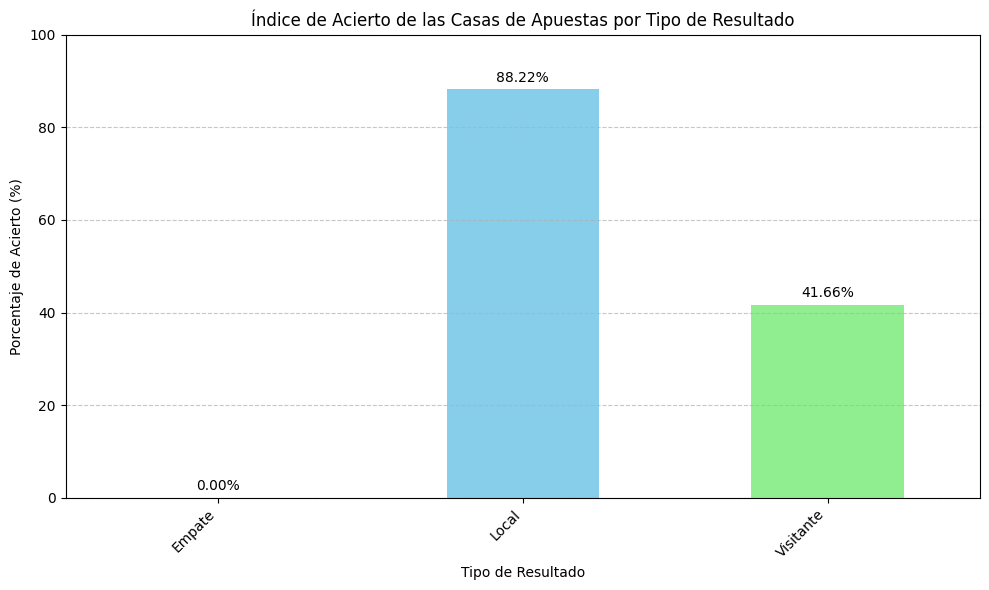

In [25]:
def determinar_resultado(row):
    if row['FTR']=='H': return 'Local'
    if row['FTR']=='A': return 'Visitante'
    return 'Empate'

# 1. Crear columna de resultado real
df['Resultado_Real'] = df.apply(determinar_resultado, axis=1)

# 2. Limpieza crítica: Eliminar filas donde falten las cuotas de Bet365
# Esto evita el error "Encountered all NA values"
df = df.dropna(subset=['B365H', 'B365D', 'B365A'])

# 3. Análisis de cuotas
cuotas = {'B365H': 'Local', 'B365D': 'Empate', 'B365A': 'Visitante'}

# Ahora idxmin no fallará porque ya no hay filas con todo NA
df['Prediccion_B365'] = df[['B365H', 'B365D', 'B365A']].idxmin(axis=1).map(cuotas)
df['Acierto'] = (df['Prediccion_B365'] == df['Resultado_Real'])

# Tabla de aciertos
acierto_por_resultado = df.groupby('Resultado_Real')['Acierto'].mean() * 100

print("Índice de acierto por tipo de resultado:")
print(acierto_por_resultado)

# Gráfico
plt.figure(figsize=(10, 6))
# Usamos un color fijo para evitar errores si el orden de los resultados varía
colores = {'Local': 'skyblue', 'Visitante': 'lightgreen', 'Empate': 'lightcoral'}
colores_lista = [colores.get(x, 'gray') for x in acierto_por_resultado.index]

acierto_por_resultado.plot(kind='bar', color=colores_lista)
plt.title('Índice de Acierto de las Casas de Apuestas por Tipo de Resultado')
plt.xlabel('Tipo de Resultado')
plt.ylabel('Porcentaje de Acierto (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')

# Añadir etiquetas de porcentaje sobre las barras
for index, value in enumerate(acierto_por_resultado):
    plt.text(index, value + 1, f'{value:.2f}%', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 8. Tendencia de Porcentajes de Resultados por Temporada

Índice de acierto de Bet365 por temporada y resultado (%):
Resultado_Real  Empate      Local  Visitante
Temporada                                   
02/03              0.0  88.636364  26.262626
03/04              0.0  86.470588  28.181818
04/05              0.0  92.700730  32.203390
05/06              0.0  91.358025  27.433628
06/07              0.0  85.465116  36.363636
07/08              0.0  85.714286  36.036036
08/09              0.0  90.760870  42.477876
09/10              0.0  89.690722  52.747253
10/11              0.0  91.370558  50.000000
11/12              0.0  85.638298  43.877551
12/13              0.0  90.476190  34.579439
13/14              0.0  86.592179  43.478261
14/15              0.0  86.549708  57.627119
15/16              0.0  87.431694  45.714286
16/17              0.0  88.397790  56.363636
17/18              0.0  84.916201  48.695652


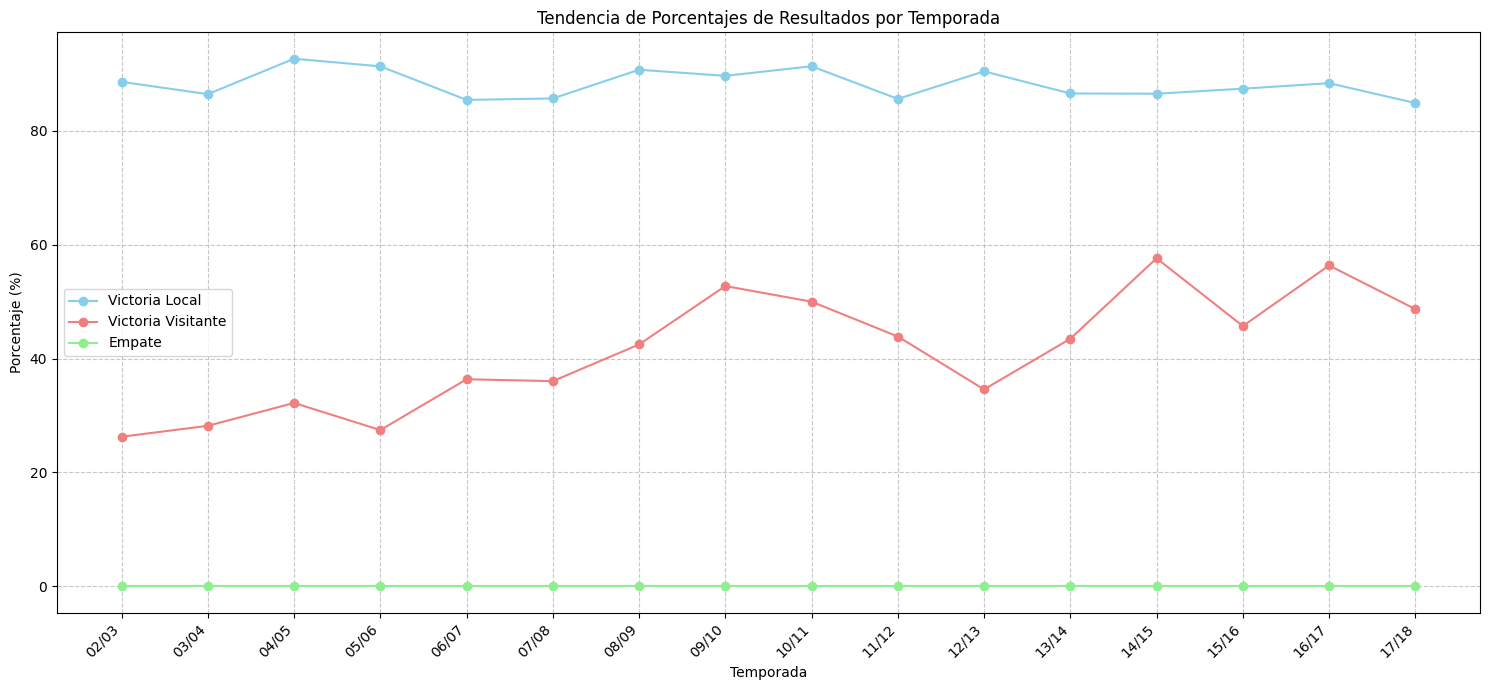

In [26]:
import matplotlib.pyplot as plt

# Calculamos el índice de acierto por tipo de resultado y por temporada
acierto_por_temporada_resultado = df.groupby(['Temporada', 'Resultado_Real'])['Acierto'].mean() * 100

# Convertimos a formato ancho para poder graficar las tendencias individuales
acierto_por_temporada_resultado = acierto_por_temporada_resultado.unstack()

print("Índice de acierto de Bet365 por temporada y resultado (%):")
print(acierto_por_temporada_resultado)

# Gráfico de líneas (Tendencia)
plt.figure(figsize=(15, 7))

# Usamos los nombres exactos de las columnas creadas tras el unstack
plt.plot(acierto_por_temporada_resultado.index, acierto_por_temporada_resultado['Local'],
         label='Victoria Local', marker='o', color='skyblue')
plt.plot(acierto_por_temporada_resultado.index, acierto_por_temporada_resultado['Visitante'],
         label='Victoria Visitante', marker='o', color='lightcoral')
plt.plot(acierto_por_temporada_resultado.index, acierto_por_temporada_resultado['Empate'],
         label='Empate', marker='o', color='lightgreen')

plt.title('Tendencia de Porcentajes de Resultados por Temporada')
plt.xlabel('Temporada')
plt.ylabel('Porcentaje (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## 9. Índice de Acierto Total de las Casas de Apuestas por Temporada

Índice de acierto total por temporada:
Resultado_Real  Empate      Local  Visitante
Temporada                                   
02/03              0.0  88.636364  26.262626
03/04              0.0  86.470588  28.181818
04/05              0.0  92.700730  32.203390
05/06              0.0  91.358025  27.433628
06/07              0.0  85.465116  36.363636
07/08              0.0  85.714286  36.036036
08/09              0.0  90.760870  42.477876
09/10              0.0  89.690722  52.747253
10/11              0.0  91.370558  50.000000
11/12              0.0  85.638298  43.877551
12/13              0.0  90.476190  34.579439
13/14              0.0  86.592179  43.478261
14/15              0.0  86.549708  57.627119
15/16              0.0  87.431694  45.714286
16/17              0.0  88.397790  56.363636
17/18              0.0  84.916201  48.695652


<Figure size 1500x700 with 0 Axes>

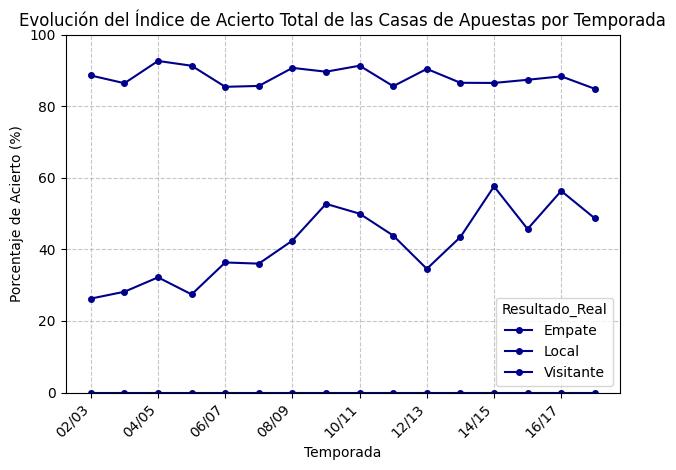

In [27]:
print("Índice de acierto total por temporada:")
print(acierto_por_temporada_resultado)

plt.figure(figsize=(15, 7))
acierto_por_temporada_resultado.plot(kind='line', marker='o', color='darkblue', markersize=4)
plt.title('Evolución del Índice de Acierto Total de las Casas de Apuestas por Temporada')
plt.xlabel('Temporada')
plt.ylabel('Porcentaje de Acierto (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

## 10. Puntos por equipos por temporadas

In [28]:
# Calcular puntos para partidos en casa (victorias y empates)
puntos_casa_total = df.groupby(['Temporada', 'HomeTeam']).apply(
    lambda x: (x['FTR'] == 'H').sum() * 3 + (x['FTR'] == 'D').sum() * 1, include_groups=False
).reset_index().rename(columns={'HomeTeam': 'Equipo', 0: 'Puntos'})

# Calcular puntos para partidos fuera (victorias y empates)
puntos_fuera_total = df.groupby(['Temporada', 'AwayTeam']).apply(
    lambda x: (x['FTR'] == 'A').sum() * 3 + (x['FTR'] == 'D').sum() * 1, include_groups=False
).reset_index().rename(columns={'AwayTeam': 'Equipo', 0: 'Puntos'})

# Concatenar los DataFrames de puntos en casa y fuera
all_team_points = pd.concat([puntos_casa_total, puntos_fuera_total])

# Agrupar por 'Temporada' y 'Equipo' y sumar los puntos para obtener el total de cada equipo en cada temporada
tabla_final = all_team_points.groupby(['Temporada', 'Equipo'])['Puntos'].sum().reset_index()

# Ordenar según lo previsto
tabla_final = tabla_final.sort_values(by=['Temporada', 'Puntos'], ascending=[True, False])
print(tabla_final)

# Función para extraer los umbrales por cada grupo de temporada
def calcular_umbrales(grupo):
    # Check if the group has enough teams for the calculations (assuming a league with at least 20 teams where 3 go down)
    if len(grupo) < 18:
        return pd.Series({
            'Puntos_Europa': np.nan, # Not enough teams for 6th place
            'Puntos_Salvacion': np.nan, # Not enough teams for 17th place
            'Brecha_Campeon_Descenso': np.nan, # Not enough teams for 1st and 18th
            'Desviacion_Estandar': grupo['Puntos'].std()
        })

    # El puesto 6 último cupo a Europa (0-indexed, so 5 is the 6th team)
    umbral_europa = grupo.iloc[5]['Puntos']

    # El puesto 17 es el último que se salva (assuming 20 teams, 18th is first to descend). iloc[16] is 17th position.
    umbral_descenso = grupo.iloc[len(grupo)-4]['Puntos']

    # Brecha entre el 1º y el 18º (el primero que desciende)
    brecha_elite = grupo.iloc[0]['Puntos'] - grupo.iloc[len(grupo)-3]['Puntos']

    return pd.Series({
        'Puntos_Europa': umbral_europa,
        'Puntos_Salvacion': umbral_descenso,
        'Brecha_Campeon_Descenso': brecha_elite,
        'Desviacion_Estandar': grupo['Puntos'].std() # Mide qué tan "pareja" es la liga
    })

# Aplicamos el análisis por temporada
analisis_competitividad = tabla_final.groupby('Temporada').apply(calcular_umbrales, include_groups=False)

print(analisis_competitividad)


    Temporada       Equipo  Puntos
11      02/03  Real Madrid      77
15      02/03     Sociedad      76
7       02/03    La Coruna      72
5       02/03        Celta      61
16      02/03     Valencia      60
..        ...          ...     ...
301     17/18   Ath Bilbao      43
312     17/18      Leganes      43
310     17/18    La Coruna      29
311     17/18   Las Palmas      22
314     17/18       Malaga      20

[320 rows x 3 columns]
           Puntos_Europa  Puntos_Salvacion  Brecha_Campeon_Descenso  \
Temporada                                                             
02/03               56.0              43.0                     41.0   
03/04               55.0              43.0                     36.0   
04/05               42.0              27.0                     36.0   
05/06               64.0              40.0                     43.0   
06/07               60.0              40.0                     37.0   
07/08               60.0              43.0                 

## 11. Gráficos competitividad de la liga

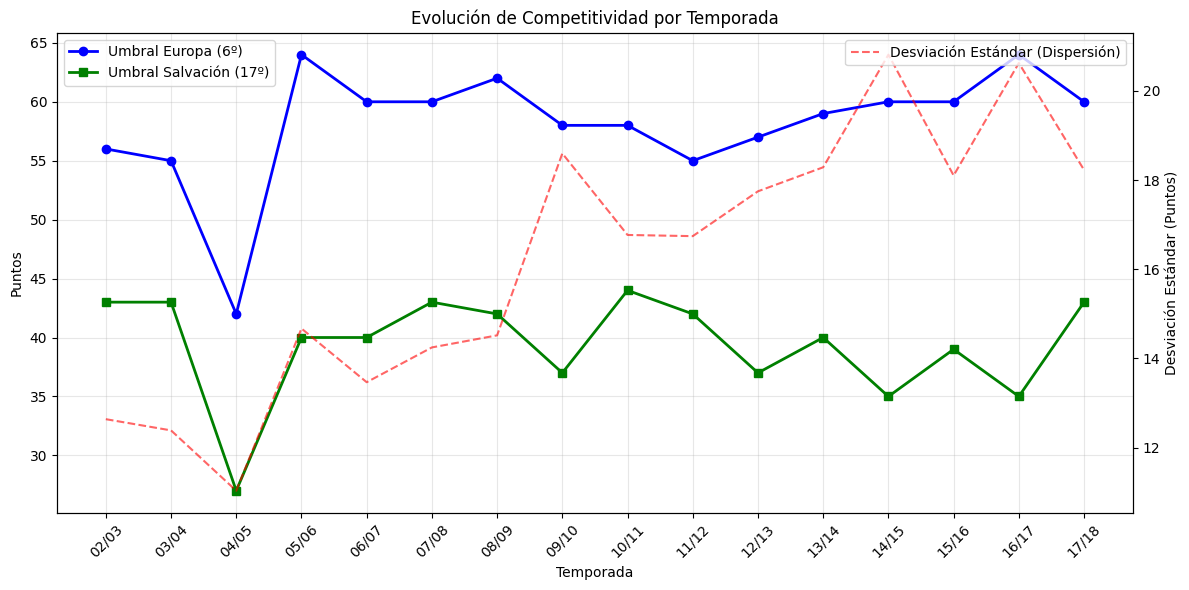

In [29]:
# Grádicos competitividad de la liga
plt.figure(figsize=(12, 6))
ax1 = plt.gca() # Eje principal para puntos

# 1. Graficar Umbrales de Puntos
ax1.plot(analisis_competitividad.index, analisis_competitividad['Puntos_Europa'],
         marker='o', label='Umbral Europa (6º)', color='blue', linewidth=2)
ax1.plot(analisis_competitividad.index, analisis_competitividad['Puntos_Salvacion'],
         marker='s', label='Umbral Salvación (17º)', color='green', linewidth=2)

ax1.set_xlabel('Temporada')
ax1.set_ylabel('Puntos')
ax1.tick_params(axis='x', rotation=45)

# 2. Eje secundario para la Desviación Estándar (Parejo de la liga)
ax2 = ax1.twinx()
ax2.plot(analisis_competitividad.index, analisis_competitividad['Desviacion_Estandar'],
         label='Desviación Estándar (Dispersión)', color='red', linestyle='--', alpha=0.6)
ax2.set_ylabel('Desviación Estándar (Puntos)')

# Títulos y Leyendas
plt.title('Evolución de Competitividad por Temporada')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()